### GEOGRAPHIC DATA SCIENCE - part 3 - spatial autocorrelation gravity models

Guest lecture by Sándor Juhász | [sandorjuhasz.com](sandorjuhasz.com)
<br>


This notebook is based on:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bE/lab_E.html
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bF/lab_F.html

In [ ]:
# if you run on Google Colab
!git clone https://github.com/sandorjuhasz/geoDS_guest_lectures.git
%cd geoDS_guest_lectures/code

!pip install pyfixest
!pip install haversine
!pip install pysal

In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine_vector, Unit
import pyfixest as pf

# pysal and esda methods for spatial autocorrelation
from pysal.lib import weights
from libpysal.io import open as psopen
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
import esda

**Spatial autocorrelation**

In this session we will be learning the ins and outs of one of the key pieces in spatial analysis: spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a positive definite matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. By convention, elements in the diagonal ($w_{ii}$) are set to zero. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. In this session, we will introduce the most commonly used ones and will show how to compute them with `PySAL`.

For this session, we will use the results of the 2016 referendum vote to leave the EU, at the local authority level. In particular, we will focus on the spatial distribution of the vote to Leave, which ended up winning. From a technical point of view, you will be working with polygons which have a value (the percentage of the electorate that voted to Leave the EU) attached to them.

All the necessary data have been assembled for convenience in a single file that contains geographic information about each local authority in England, Wales and Scotland, as well as the vote attributes. The file is in the geospatial format [GeoPackage](http://www.geopackage.org/), which presents several advantages over the more traditional shapefile (chief among them, the need of a single file instead of several).

In [33]:
# read the file in
br = gpd.read_file("../data/brexit.gpkg")
print(br.crs)

EPSG:4326


In [34]:
br.head(2)

,objectid,lad16cd,lad16nm,Pct_Leave,geometry
0,1,E06000001,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.27250 54..."
1,2,E06000002,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.23431 54..."


In [35]:
# index table on the LAD ID -- local authority IDs
br = br.set_index("lad16cd", drop=False)
br.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16cd    380 non-null    object  
 2   lad16nm    380 non-null    object  
 3   Pct_Leave  380 non-null    float64 
 4   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 17.8+ KB


<Axes: >

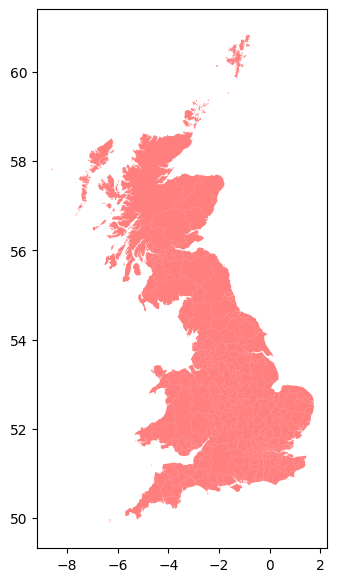

In [36]:
# plot for visual check
fig, ax = plt.subplots(1,1, figsize=(5,7))
br.plot(ax=ax, alpha=0.5, color='red')

For this example, we will show how to build a queen contiguity matrix, which considers two observations as neighbors if they share at least one point of their boundary. In other words, for a pair of local authorities in the dataset to be considered neighbours under this $W$, they will need to be sharing border or, in other words, "touching" each other to some degree.

Technically speaking, we will approach building the contiguity matrix. We will begin with a `GeoDataFrame` and pass it on to the queen contiguity weights builder in `PySAL` (`ps.weights.Queen.from_dataframe`). We will also make sure our table of data is previously indexed on the local authority code, so the $W$ is also indexed on that form.

In [70]:
# create the spatial weights matrix
w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_80836/1574887461.py:2: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(br, idVariable="lad16cd")


The command above creates an object `w` of the class `W`. This is the format in which spatial weights matrices are stored in `PySAL`. By default, the weights builder (`Queen.from_dataframe`) will use the index of the table, which is useful so we can keep everything in line easily. There is a warning message that we will need to consider in our analysis later.

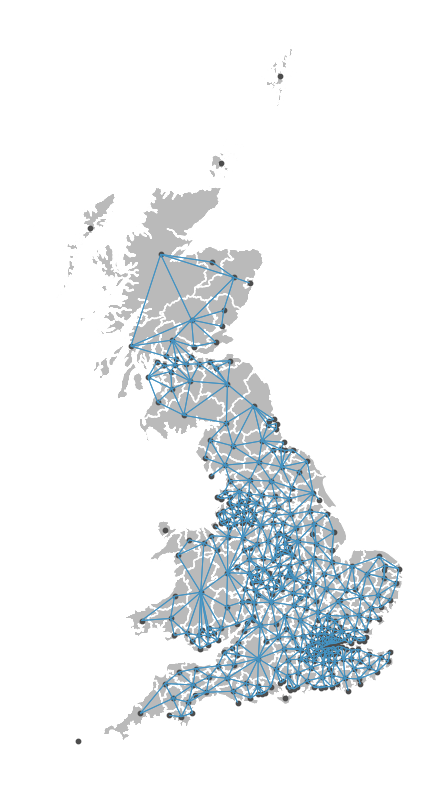

In [38]:
# visualize the weights -- using the libpysal method plot_spatial_weights
# use the British National Grid, 27700 (crs)
plot_spatial_weights(w, br.to_crs(epsg=27700), indexed_on="lad16cd");

In [39]:
list(w)[:3]

[('E06000001', {'E06000047': 1.0, 'E06000004': 1.0}),
 ('E06000002', {'E07000164': 1.0, 'E06000003': 1.0, 'E06000004': 1.0}),
 ('E06000003', {'E07000164': 1.0, 'E06000002': 1.0, 'E07000168': 1.0})]

A `W` object can be queried to find out about the contiguity relations it contains. For example, if we would like to know who is a neighbor of observation `E06000002`:

In [40]:
w['E06000002']['E06000004']

1.0

`W` objects also have a direct way to provide a list of all the neighbors or their weights for a given observation. This is thanks to the `neighbors` and `weights` attributes:

In [41]:
w.neighbors['E06000002']

['E07000164', 'E06000003', 'E06000004']

In [42]:
w.weights['E06000002']

[1.0, 1.0, 1.0]

Once created, `W` objects can provide much information about the matrix, beyond the basic attributes one would expect. We have direct access to the number of neighbors each observation has via the attribute `cardinalities`. For example, to find out how many neighbors observation `E06000002` has:

In [43]:
w.cardinalities['E06000002']

3

Since `cardinalities` is a dictionary, it is direct to convert it into a `Series` object:

In [44]:
queen_card = pd.Series(w.cardinalities)
queen_card.head()

E06000001    2
E06000002    3
E06000003    3
E06000004    5
E06000005    4
dtype: int64

This allows, for example, to access quick plotting, which comes in very handy to get an overview of the size of neighborhoods in general:

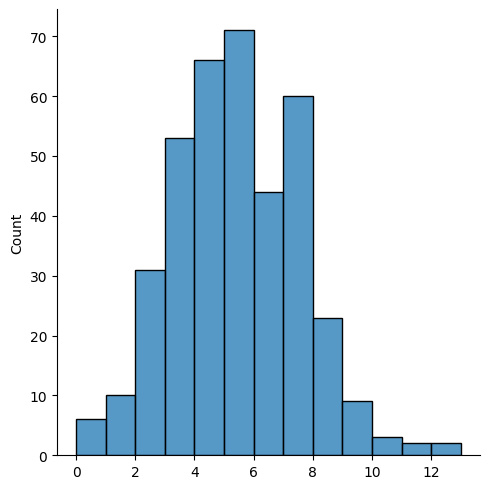

In [45]:
p = sns.displot(queen_card, bins=13);

In [46]:
w.histogram

[(0, 6),
 (1, 10),
 (2, 31),
 (3, 53),
 (4, 66),
 (5, 71),
 (6, 44),
 (7, 60),
 (8, 23),
 (9, 9),
 (10, 3),
 (11, 2),
 (12, 1),
 (13, 1)]

In [47]:
# number of observations
w.n

380

In [48]:
# average number of neighbors
w.mean_neighbors

4.936842105263158

In [49]:
# min number of neighbors
w.min_neighbors

0

In [50]:
# max number of neighbors
w.max_neighbors

13

In [51]:
# order of IDs (first five only in this case)
w.id_order[:5]

['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000005']

In [52]:
# islands (observations disconnected)
w.islands

['E06000046', 'E06000053', 'S12000013', 'S12000023', 'S12000027', 'W06000001']

Note how we have "islands". Remember these are islands not necessarily in the geographic sense (although some of them will be), but in the mathematical sense of the term: local authorities that are not sharing border with any other one and thus do not have any neighbors. We can inspect and map them to get a better sense of what we are dealing with:

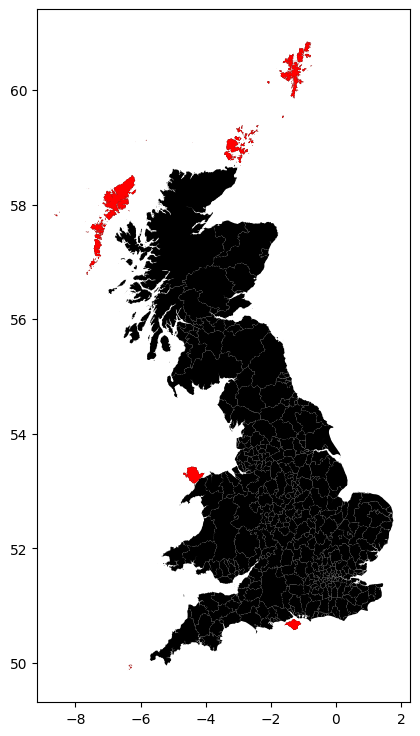

In [53]:
ax = br.plot(color='k', figsize=(9, 9))
br.loc[w.islands, :].plot(color='red', ax=ax);

In this case, all the islands are indeed "real" islands. These cases can create issues in the analysis and distort the results. There are several solutions to this situation such as connecting the islands to other observations through a different criterium (e.g. nearest neighbor), and then combining both spatial weights matrices. For convenience, we will remove them from the dataset because they are a small sample and their removal is likely not to have a large impact in the calculations.

Technically, this amounts to a subsetting, for which we will use the `drop` command, which comes in very handy in these cases:

In [54]:
br = br.drop(w.islands)

Once we have the set of local authorities that are not an island, we need to re-calculate the weights matrix:

In [55]:
w = weights.Queen.from_dataframe(br, idVariable="lad16cd")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_80836/397159846.py:1: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  w = weights.Queen.from_dataframe(br, idVariable="lad16cd")


And, finally, let us row-standardize it to make sure every row of the matrix sums up to one:

In [56]:
# Row standardize the matrix
w.transform = "R"

Now, because we have row-standardize them, the weight given to each of the three neighbors is 0.33 which, all together, sum up to one.

In [57]:
w['E06000002']

{'E07000164': 0.3333333333333333,
 'E06000003': 0.3333333333333333,
 'E06000004': 0.3333333333333333}

If we re-plot the connectivity graph now, the islands are gone and we have one connected component:

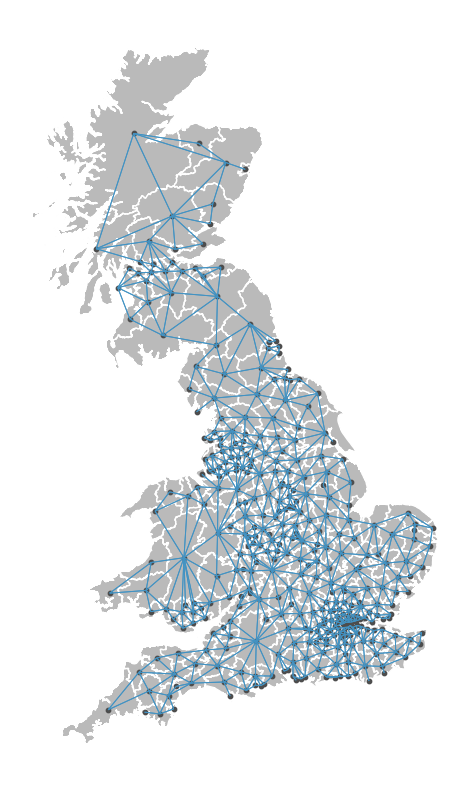

In [58]:
plot_spatial_weights(w, br.to_crs(epsg=27700), indexed_on="lad16cd"); # Use the British National Grid, 27700

**Exercise**

Calculate the queen contiguity matrix for Budapest districts to figure out the neighbors of IX. district.

(Remember -- CRS for Hungary is 23700)

In [68]:
# districts of Budapest
bp_district = gpd.read_file("../data/shape_files/budapest_districts_shape/budapest_districts_shape.shp")


**Spatial lag**

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself:

$$
Y_{sl} = W Y
$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

Since we are using row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as the average value of $Y$ in the neighborhood of $i$.

Now that we have the data and the spatial weights matrix ready, we can start by computing the spatial lag of the percentage of votes that went to leave the EU. We can calculate the spatial lag for the variable `Pct_Leave` and store it directly in the main table with the following line of code:

In [71]:
br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

Let us have a quick look at the resulting variable, as compared to the original one:

In [72]:
br[['lad16cd', 'Pct_Leave', 'w_Pct_Leave']].head()

,lad16cd,Pct_Leave,w_Pct_Leave
lad16cd,,,
E06000001,E06000001,69.57,119.28
E06000002,E06000002,65.48,181.58
E06000003,E06000003,66.19,181.13
E06000004,E06000004,61.73,302.44
E06000005,E06000005,56.18,229.72


The way to interpret the spatial lag (`w_Pct_Leave`) for say the first observation is as follow: Hartlepool, where 69,6% of the electorate voted to leave is surrounded by neighbouring local authorities where, on average, almost 60% of the electorate also voted to leave the EU. For the purpose of illustration, we can in fact check this is correct by querying the spatial weights matrix to find out Hartepool's neighbors: 

In [73]:
w.neighbors['E06000001']

['E06000047', 'E06000004']

In [74]:
# check their values
neis = br.loc[w.neighbors['E06000001'], 'Pct_Leave']
neis

lad16cd
E06000047    57.55
E06000004    61.73
Name: Pct_Leave, dtype: float64

And the average value, which we saw in the spatial lag is 61.8, can be calculated as follows:

In [75]:
neis.mean()

59.64

For some of the techniques we will be seeing below, it makes more sense to operate with the standardized version of a variable, rather than with the raw one. Standardizing means to substract the average value and divide by the standard deviation each observation of the column. This can be done easily with a bit of basic algebra in Python:

In order to easily compare different scatter plots and spot outlier observations, it is common practice to standardize the values of the variable before computing its spatial lag and plotting it. This can be accomplished by substracting the average value and dividing the result by the standard deviation:

$$
z_i = \dfrac{y - \bar{y}}{\sigma_y}
$$

where $z_i$ is the standardized version of $y_i$, $\bar{y}$ is the average of the variable, and $\sigma$ its standard deviation.

Creating a standardized Moran Plot implies that average values are centered in the plot (as they are zero when standardized) and dispersion is expressed in standard deviations, with the rule of thumb of values greater or smaller than two standard deviations being *outliers*. A standardized Moran Plot also partitions the space into four quadrants that represent different situations:

1. High-High (*HH*): values above average surrounded by values above average.
1. Low-Low (*LL*): values below average surrounded by values below average.
1. High-Low (*HL*): values above average surrounded by values below average.
1. Low-High (*LH*): values below average surrounded by values above average.

In [76]:
br['Pct_Leave_std'] = (br['Pct_Leave'] - br['Pct_Leave'].mean()) / br['Pct_Leave'].std()

Finally, to be able to explore the spatial patterns of the standardized values, also called sometimes $z$ values, we need to create its spatial lag:

In [77]:
br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])

In [79]:
br.head(3)

,objectid,lad16cd,lad16nm,Pct_Leave,geometry,w_Pct_Leave,Pct_Leave_std,w_Pct_Leave_std
lad16cd,,,,,,,,
E06000001,1,E06000001,Hartlepool,69.57,"MULTIPOLYGON (((-1.27024 54.72716, -1.27250 54...",119.28,1.566940,1.228176
E06000002,2,E06000002,Middlesbrough,65.48,"MULTIPOLYGON (((-1.23001 54.58410, -1.23431 54...",181.58,1.174476,2.097509
E06000003,3,E06000003,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-1.13717 54.64693, -1.13746 54...",181.13,1.242605,2.054329


**Global Spatial autocorrelation**

Global spatial autocorrelation relates to the overall geographical pattern present in the data. Statistics designed to measure this trend thus characterize a map in terms of its degree of clustering and summarize it. This summary can be visual or numerical. In this section, we will walk through an example of each of them: the Moran Plot, and Moran's I statistic of spatial autocorrelation.

**Moran plot**

The moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is essentially a traditional scatter plot in which the variable of interest is displayed against its spatial lag. In order to be able to interpret values as above or below the mean, and their quantities in terms of standard deviations, the variable of interest is usually standardized by substracting its mean and dividing it by its standard deviation.

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot in Python, provided we have standardized the variable and calculated its spatial lag beforehand:

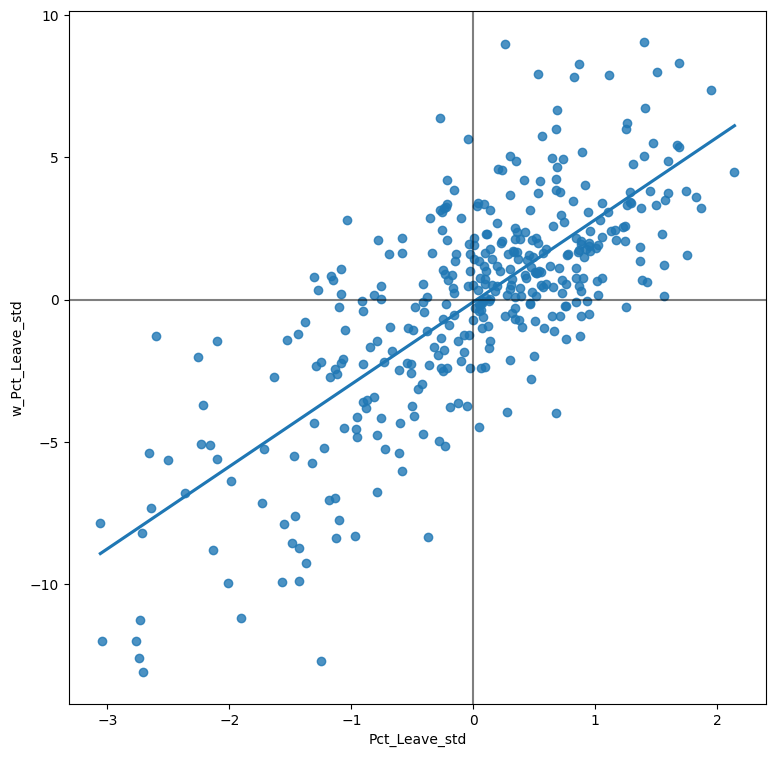

In [80]:
# setup the figure and axis
fig, ax = plt.subplots(1,1, figsize=(9, 9))

# plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)

# add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

The figure above displays the relationship between the standardized percentage which voted to Leave the EU (`Pct_Leave_std`) and its spatial lag which, because the $W$ that was used is row-standardized, can be interpreted as the average percentage which voted to Leave in the surrounding areas of a given Local Authority. In order to guide the interpretation of the plot, a linear fit is also included in the post. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line. 

The plot displays a positive relationship between both variables. This is associated with the presence of *positive* spatial autocorrelation: similar values tend to be located close to each other. This means that the *overall trend* is for high values to be close to other high values, and for low values to be surrounded by other low values. This however does not mean that this is only situation in the dataset: there can of course be particular cases where high values are surrounded by low ones, and viceversa. But it means that, if we had to summarize the main pattern of the data in terms of how clustered similar values are, the best way would be to say they are positively correlated and, hence, clustered over space.

In the context of the example, this can be interpreted along the lines of: local authorities display positive spatial autocorrelation in the way they voted in the EU referendum. This means that local authorities with high percentage of Leave voters tend to be located nearby other local authorities where a significant share of the electorate also voted to Leave, and viceversa.

**Moran's I**

The Moran Plot is an excellent tool to explore the data and get a good sense of how much values are clustered over space. However, because it is a graphical device, it is sometimes hard to condense its insights into a more concise way. For these cases, a good approach is to come up with a statistical measure that summarizes the figure. This is exactly what Moran's I is meant to do. 

Very much in the same way the mean summarizes a crucial element of the distribution of values in a non-spatial setting, so does Moran's I for a spatial dataset. Continuing the comparison, we can think of the mean as a single numerical value summarizing a histogram or a kernel density plot. Similarly, Moran's I captures much of the essence of the Moran Plot. In fact, there is an even close connection between the two: the value of Moran's I corresponds with the slope of the linear fit overlayed on top of the Moran Plot.

In order to calculate Moran's I in our dataset, we can call a specific function in `PySAL` directly:

In [81]:
mi = esda.Moran(br['Pct_Leave'], w)

Note how we do not need to use the standardized version in this context as we will not represent it visually.

The method `ps.Moran` creates an object that contains much more information than the actual statistic. If we want to retrieve the value of the statistic, we can do it this way:

In [82]:
mi.I

0.6228641407137806

The other bit of information we will extract from Moran's I relates to statistical inference: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics?

The specific details of the mechanism to calculate this are beyond the scope of the session, but it is important to know that a small enough p-value associated with the Moran's I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern that we would expect if the values had been randomly allocated to a particular location.

The most reliable p-value for Moran's I can be found in the attribute `p_sim`:

In [83]:
mi.p_sim

0.001

That is just 0.1% and, by standard terms, it would be considered statistically significant. We can quickly ellaborate on its intuition. What that 0.001 (or 0.1%) means is that, if we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran's I statistic for each of those maps, only 0.1% of them would display a larger (absolute) value than the one we obtain from the real data, and the other 99.9% of the random maps would receive a smaller (absolute) value of Moran's I. If we remember again that the value of Moran's I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values for the Leave votes is more concentrated than if the values had been allocated following a completely spatially random process, hence the statistical significance.


Once we have calculated Moran's I and created an object like `mi`, we can use some of the functionality in `splot` to replicate the plot above more easily:

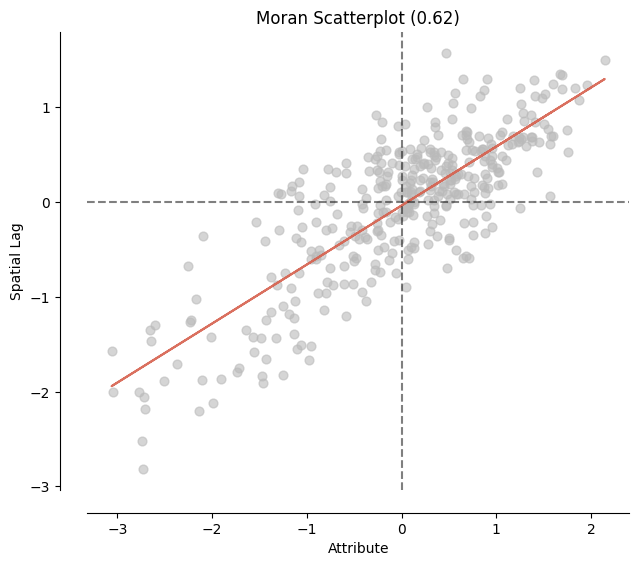

In [84]:
moran_scatterplot(mi);

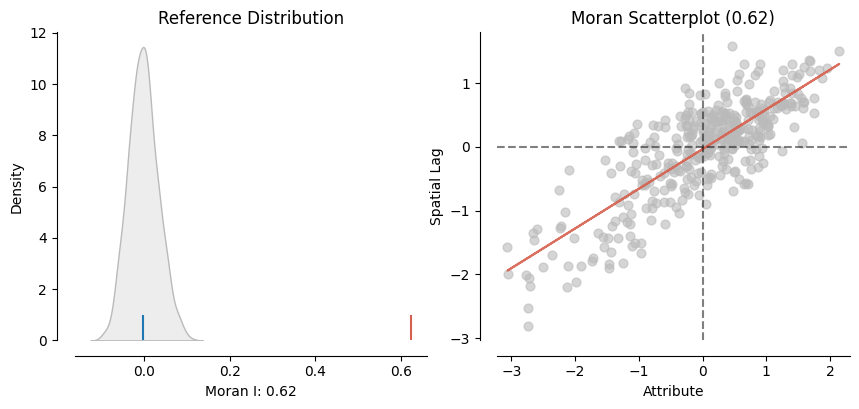

In [85]:
plot_moran(mi);

As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively correlated over space. In terms of our initial goal to find spatial structure in the attitude towards Brexit, this view seems to align: if the vote had no such structure, it should not show a pattern over space -technically, it would show a random one.

**Local Spatial autocorrelation**

Moran's I is good tool to summarize a dataset into a single value that informs about its degree of *clustering*. However, it is not an appropriate measure to identify areas within the map where specific values are located. In other words, Moran's I can tell us values are clustered overall, but it will not inform us about *where* the clusters are. For that purpose, we need to use a *local* measure of spatial autocorrelation. Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as *global* measures do. Because of that, they are not good a summarizing a map, but they allow to obtain further insight.

In this session, we will consider [Local Indicators of Spatial Association](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x/abstract) (LISAs), a local counter-part of global measures like Moran's I. At the core of these method is a classification of the observations in a dataset into four groups derived from the Moran Plot: high values surrounded by high values (HH), low values nearby other low values (LL), high values among low values (HL), and viceversa (LH). Each of these groups are typically called "quadrants". An illustration of where each of these groups fall into the Moran Plot can be seen below:

Text(-1.5, -2.5, 'LL')

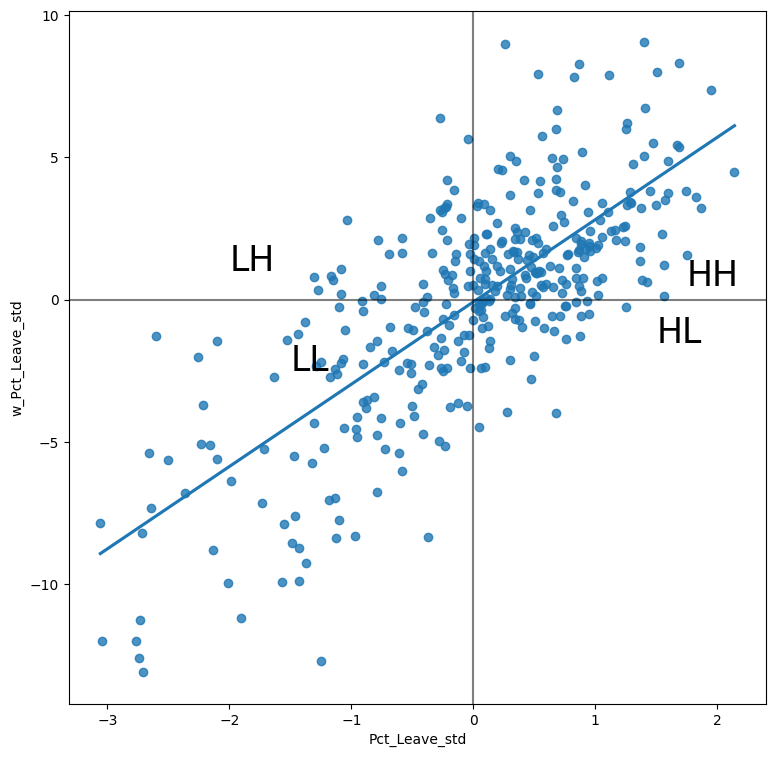

In [86]:
# setup the figure and axis
fig, ax = plt.subplots(1,1, figsize=(9, 9))

# plot values
sns.regplot(x='Pct_Leave_std', y='w_Pct_Leave_std', data=br, ci=None)

# add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.5, "HH", fontsize=25)
plt.text(1.5, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1.5, -2.5, "LL", fontsize=25)

So far we have classified each observation in the dataset depending on its value and that of its neighbors. This is only half way into identifying areas of unusual concentration of values. To know whether each of the locations is a *statistically significant* cluster of a given kind, we again need to compare it with what we would expect if the data were allocated in a completely random way. After all, by definition, every observation will be of one kind of another, based on the comparison above. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. 

This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as many statistics as original observations.

LISAs are widely used in many fields to identify clusters of values in space. They are a very useful tool that can quickly return areas in which values are concentrated and provide *suggestive* evidence about the processes that might be at work. For that, they have a prime place in the exploratory toolbox. Examples of contexts where LISAs can be useful include: identification of spatial clusters of poverty in regions, detection of ethnic enclaves, delineation of areas of particularly high/low activity of any phenomenon, etc.

In Python, we can calculate LISAs in a very streamlined way thanks to `PySAL`:

In [87]:
lisa = esda.Moran_Local(br['Pct_Leave'], w)

All we need to pass is the variable of interest -percentage of Leave votes- and the spatial weights that describes the neighborhood relations between the different observation that make up the dataset.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember that we are calculating a statistic for every sigle observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. Instead, what is typically done is to create a map, a cluster map as it is usually called, that extracts the significant observations (those that are highly unlikely to have come from pure chance) and plots them with a specific color depending on their quadrant category.

All of the needed pieces are contained inside the `lisa` object we have created above. But, to make the map making more straightforward, it is convenient to pull them out and insert them in the main data table, `br`:

In [88]:
# break observations into significant or not
br['significant'] = lisa.p_sim < 0.05

# store the quadrant they belong to
br['quadrant'] = lisa.q

Let us stop for second on these two steps. First, the `significant` column. Similarly as with global Moran's I, `PySAL` is automatically computing a p-value for each LISA. Because not every observation represents a statistically significant one, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar situation from pure chance. Following a similar reasoning as with global Moran's I, we select 5% as the threshold for statistical significance. To identify these values, we create a variable, `significant`, that contains `True` if the p-value of the observation is satisfies the condition, and `False` otherwise. We can check this is the case:

In [89]:
br['significant'].head()

lad16cd
E06000001    False
E06000002    False
E06000003    False
E06000004     True
E06000005    False
Name: significant, dtype: bool

In [90]:
# and the first five p-values can be checked by
lisa.p_sim[:5]

array([0.176, 0.093, 0.098, 0.044, 0.192])

Note how the third and fourth are smaller than 0.05, as the variable `significant` correctly identified.

Second, the quadrant each observation belongs to. This one is easier as it comes built into the `lisa` object directly:

In [91]:
br['quadrant']

lad16cd
E06000001    1
E06000002    1
E06000003    1
E06000004    1
E06000005    1
            ..
W06000020    1
W06000021    2
W06000022    4
W06000023    1
W06000024    1
Name: quadrant, Length: 374, dtype: int64

The correspondence between the numbers in the variable and the actual quadrants is as follows:

* 1: HH
* 2: LH
* 3: LL
* 4: HL

With these two elements, `significant` and `quadrant`, we can build a typical LISA cluster map combining the mapping skills with what we have learned about subsetting and querying tables:

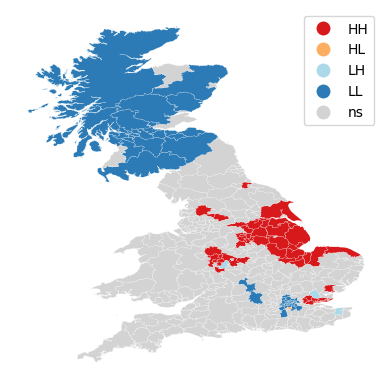

In [92]:
# create a quick LISA cluster map with `splot`:
lisa_cluster(lisa, br);

Or, if we want to have more control over what is being displayed, and how each component is presented, we can "cook" the plot ourselves:

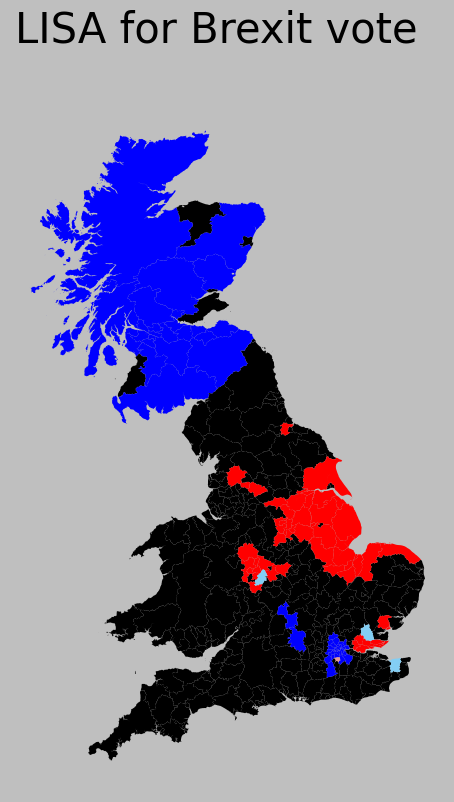

In [93]:
# setup the figure and axis
fig, ax = plt.subplots(1,1, figsize=(9, 9))

# plot insignificant clusters
ns = br.loc[br['significant']==False, 'geometry']
ns.plot(ax=ax, color='k')

# plot HH clusters
hh = br.loc[(br['quadrant']==1) & (br['significant']==True), 'geometry']
hh.plot(ax=ax, color='red')

# plot LL clusters
ll = br.loc[(br['quadrant']==3) & (br['significant']==True), 'geometry']
ll.plot(ax=ax, color='blue')

# plot LH clusters
lh = br.loc[(br['quadrant']==2) & (br['significant']==True), 'geometry']
lh.plot(ax=ax, color='#83cef4')

# plot HL clusters
hl = br.loc[(br['quadrant']==4) & (br['significant']==True), 'geometry']
hl.plot(ax=ax, color='#e59696')

# style and draw
fig.suptitle('LISA for Brexit vote', size=30)
fig.set_facecolor('0.75')
ax.set_axis_off()

The map above displays the LISA results of the Brexit vote. In bright red, we find those local authorities with an unusual concentration of high Leave voters surrounded also by high levels of Leave vote. This corresponds with areas in the East of England, the Black Country, and East of London. In light red, we find the first type of *spatial outliers*. These are areas with high Leave vote but surrounded by areas with low support for leaving the EU (e.g. central London). Finally, in light blue we find the other type of spatial outlier: local authorities with low Leave support surrounded by other authorities with high support.

The substantive interpretation of a LISA map needs to relate its output to the original intention of the analyst who created the map. In this case, our original idea was to explore the spatial structure of support to leaving the EU. The LISA proves a fairly useful tool in this context. Comparing the LISA map above with the choropleth we started with, we can interpret the LISA as "simplification" of the detailed but perhaps too complicated picture in the choropleth that focuses the reader's attention to the areas that display a particularly high concentration of (dis)similar values, helping the spatial structure of the vote emerge in a more explicit way. The result of this highlights the relevance that the East of England and the Midlands had in voting to Leave, as well as the regions of the map where there was a lot less excitement about Leaving.

The results from the LISA statistics can be connected to the Moran plot to visualise where in the scatter plot each type of polygon falls:

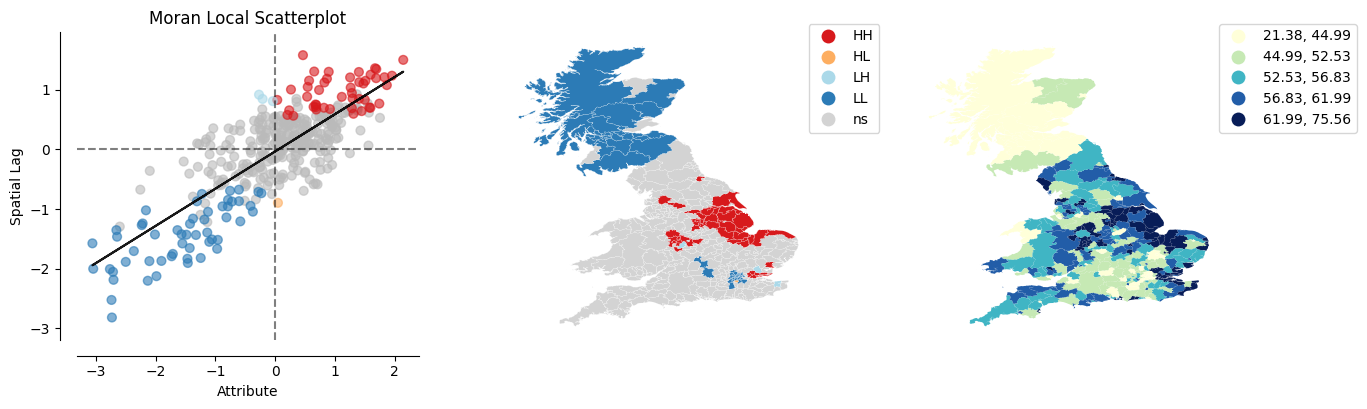

In [94]:
plot_local_autocorrelation(lisa, br, 'Pct_Leave');

**Exercise**

Estimate the spatial autocorrelation of Bars in Budapest districts. Are districts with high number of bars surrounded by other districts with high number of bars?

In [98]:
# bar data
bp_bars = gpd.read_file("../data/budapest_bars.geojson")
bp_districts = gpd.read_file("../data/shape_files/budapest_districts_shape/budapest_districts_shape.shp")


**Gravity model estimation on spatial social network data**

In case we work with data on socio-economic connections (such as internation trade, social network ties, commuting data,...) one of the main questions is how distance dependent connections are. In the following we will use a dataset on geolocated Twitter mutual followerships aggregated to census tract pairs in Boston, MA, US. This data allows us to test the distance dependence of social connections inside cities in a very controlled way.

(1) Map the Twitter social network

(2) Run a gravity model (regression) that explains the number of connections by distance, considering as many other features in the census data as possible.

In [101]:
# Boston -- Twitter connections
el = pd.read_csv("../data/boston_US_twitter_edgelist.csv", sep=";")
el.head(2)

,tract_home1,tract_home2,nr_social_ties
0,14000US25009201100,14000US25009201100,8
1,14000US25009201100,14000US25009202101,1


In [102]:
# Boston census data
census = gpd.read_file("../data/boston_census_tracts.geojson")
census.head(2)

,tract_id,population2012,income2012,education_bachelor2012,white2012,black2012,geometry
0,14000US25009203302,4576,60886.0,1196,4452,27,"POLYGON ((-70.87373 42.51921, -70.85809 42.527..."
1,14000US25009220101,4108,43769.0,1060,4095,0,"POLYGON ((-70.63999 42.63502, -70.63968 42.636..."


In [103]:
# construct nodelist with coordinates for census tract centroids
census["lat"] = census.centroid.y
census["lon"] = census.centroid.x
nodelist = pd.DataFrame({"tract_id": pd.concat([el["tract_home1"], el["tract_home2"]]).unique()})

# add geometry from census tract table
nodelist = pd.merge(
    nodelist,
    census[["tract_id", "lat", "lon"]],
    on="tract_id",
    how="left"
)

# centroid of census tracts
nodelist = gpd.GeoDataFrame(nodelist)

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_80836/508139130.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census["lat"] = census.centroid.y
/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_80836/508139130.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census["lon"] = census.centroid.x


In [105]:
# point for nodes
def create_point(r):
    return Point([r["lon"],r["lat"]])

In [106]:
# nodelist geodataframe construction
nodelist["geometry"] = nodelist.apply(create_point, axis=1)
nodes_gdf = gpd.GeoDataFrame(nodelist, geometry="geometry", crs="epsg:4326")

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_80836/249874043.py:2: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  nodelist["geometry"] = nodelist.apply(create_point, axis=1)


In [107]:
# construct edgelist
el = pd.merge(
    el,
    census,
    left_on="tract_home1",
    right_on="tract_id",
    how="left"
)
el = pd.merge(
    el,
    census,
    left_on="tract_home2",
    right_on="tract_id",
    how="left",
    suffixes=["_1", "_2"]
)

In [108]:
# line for edges
def create_polyline(r):
    return LineString([[r["lon_1"],r["lat_1"]],[r["lon_2"],r["lat_2"]]])

In [109]:
# edgelist geodataframe construction
el["geometry"] = el.apply(create_polyline, axis=1)
edges_gdf = gpd.GeoDataFrame(el, geometry="geometry", crs="epsg:4326")

(-71.88759110596371, -70.47057856519389, 41.60862463551035, 43.557816927098344)

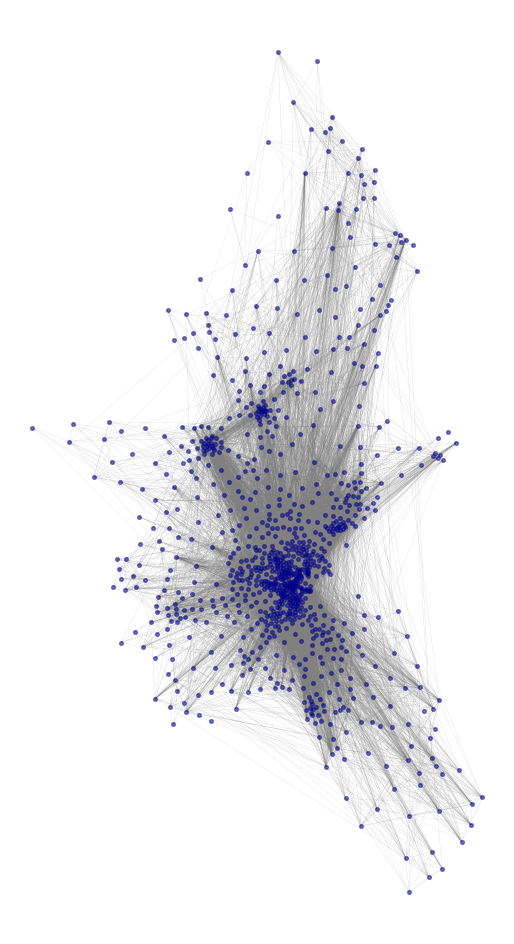

In [110]:
# map of social connections -- geolocated nodes and edges
fig, ax = plt.subplots(1,1, figsize=(12,12))
nodes_gdf.plot(ax=ax, markersize=7, color="darkblue", alpha=0.5, zorder=3)
edges_gdf.plot(ax=ax, lw=0.075, color="grey", alpha=0.4, zorder=2)
ax.axis('off')

**proximate things are more related than distant things?**

In [116]:
# coordinate pair for tract1 and tract2
edges_gdf["coords1"] = list(
    zip(edges_gdf["lat_1"], edges_gdf["lon_1"])
)
edges_gdf["coords2"] = list(
    zip(edges_gdf["lat_2"], edges_gdf["lon_2"])
)

# distance calculation
edges_gdf["distance"] = haversine_vector(
    edges_gdf["coords1"].tolist(), edges_gdf["coords2"].tolist()
)

In [119]:
# variable manipulation for regression
reg_df = pd.DataFrame(edges_gdf[["nr_social_ties", "distance", "income2012_1", "income2012_2", "population2012_1", "population2012_2", "tract_home1", "tract_home2"]])

reg_df["log_social_ties"] = np.log10(reg_df["nr_social_ties"] + 1)
reg_df["log_distance"] = np.log10(reg_df["distance"] + 1)
reg_df["income_abs_diff"] = np.log10(abs(reg_df["income2012_1"] - reg_df["income2012_2"]) + 1)
reg_df["population_product"] = np.log10(reg_df["population2012_1"] * reg_df["population2012_2"] + 1)

In [120]:
# models
m1 = pf.feols("log_social_ties ~ population_product + log_distance | tract_home1 + tract_home2", data=reg_df)
m2 = pf.feols("log_social_ties ~ population_product + income_abs_diff | tract_home1 + tract_home2", data=reg_df)
m3 = pf.feols("log_social_ties ~ population_product + log_distance + income_abs_diff | tract_home1 + tract_home2", data=reg_df)

pf.etable([m1, m2, m3], type="md")

index                          est1             est2             est3
------------------  ---------------  ---------------  ---------------
depvar              log_social_ties  log_social_ties  log_social_ties
---------------------------------------------------------------------
population_product           0.014           -0.011           -0.005
                            (0.009)          (0.012)          (0.011)
log_distance             -0.188***                         -0.168***
                            (0.004)                           (0.004)
income_abs_diff                           -0.067***        -0.034***
                                             (0.002)          (0.002)
---------------------------------------------------------------------
tract_home1                       x                x                x
tract_home2                       x                x                x
---------------------------------------------------------------------
Observations           

**Exercise**

Add controls on racial similarity. You can use chatGPT to find a suitable solution.